# SEP532 인공지능 이론과 실제
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## Recurrent Neural Networks
### Word embeddings
Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, you will look at three strategies for doing so.

#### Representing text as numbers: One-hot encodings 
First method for representing the text as numbers is an "one-hot" encode each word in the vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

![Diagram of one-hot encodings](images/one-hot.png)

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

**Key point:** This approach is **inefficient**. A one-hot encoded vector is **sparse (meaning, most indicices are zero)**. Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.


#### Encode each word with a unique number
There is another apporach of one-hot encoding. This is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then **encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]**. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach:
- The integer-encoding is arbitrary (**it does not capture any relationship between words**).
- An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

#### Word embeddings
Word embeddings give us a way to use an **efficient, dense representation in which similar words have a similar encoding**. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify).

Instead of specifying the values for the embedding manually, they are **trainable parameters** (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. **A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.**

![Diagram of an embedding](images/embeddings.png)

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

- Visualization of trained word embedding through [Embedding Projector](http://projector.tensorflow.org/)

#### Using the Embedding layer
Keras makes it easy to use word embeddings. Let's take a look at the [Embedding layer](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Embedding).

`tf.keras.layers.Embedding(input_dim, output_dim))`: Turns positive integers (indexes) into dense vectors of fixed size.
 - input_dim:  int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
 - output_dim: int >= 0. Dimension of the dense embedding.
 - Input shape: 2D tensor with shape: (batch_size, input_length).
 - Output shape: 3D tensor with shape: (batch_size, input_length, output_dim).

In [1]:
import tensorflow as tf

# The Embedding layer takes at least two arguments:
# the number of possible words in the vocabulary, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 32.
embedding_layer = tf.keras.layers.Embedding(1000, 32)

The Embedding layer can be understood as a **lookup table** that maps from integer indices (which stand for specific words) to dense vectors. The dimensionality of the embedding is a parameter you can experiment with to see what works well for your problem (much in the same way you would experiment with the number of neurons in a Dense layer).

When you create an Embedding layer, the weights for the embedding are randomly initialized. During training, they are gradually adjusted via backpropagation. Once trained, **the learned word embeddings will roughly encode similarities between words** (as they were learned for the specific problem your model is trained on).

As input, the Embedding layer takes a 2D tensor of integers, of shape (batches, sequence_length), where each entry is a _sequence of integers_. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10). All sequences in a batch must have the same length, so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

As output, the embedding layer returns a 3D floating point tensor, of shape (batches, sequence_length, embedding_dimensionality). Such a 3D tensor can then be processed by a RNN layer, or can simply be flattened or pooled and processed by a Dense layer.

#### Learning embeddings from scratch
We will train a sentiment classifier on IMDB movie reviews we previously did. In the process, we will learn embeddings from scratch. 

In [3]:
vocab_size = 10000
imdb = tf.keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

As imported, the text of reviews is integer-encoded (each integer represents a specific word in a dictionary).

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


#### Convert the integers back to words
It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [19]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
# Create dict class using key(words)-value(integers)
word_index = {k:(v+3) for k,v in word_index.items()} 

# Set new keys for us 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# Key: integers, Value: words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print("Train_data[0]: {}\n".format(train_data[0]))
decode_review(train_data[0])

Train_data[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]



"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

Movie reviews can be different lengths. We will use the [`pad_sequences`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function to standardize the lengths of the reviews.

In [20]:
# Standardize the lenghts of data to use it as an input of model
maxlen = 500

# Return the 2D Numpy array of shape (train_data, maxlen) 
# by transfoming the input data with zeros peddings 
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                           value=word_index["<PAD>"],
                                                           padding='post', # 'pre' or 'post'
                                                           maxlen=maxlen)

test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                          value=word_index["<PAD>"],
                                                          padding='post',
                                                          maxlen=maxlen)

In [24]:
print("Len of data: {}".format(len(train_data[0])))
print(train_data[0])

Len of data: 500
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92

#### Create simple embedding model 

We will use the Keras Sequential API to define our model.
- The first layer is an **Embedding layer**. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index (convert integers to floating values). These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`(3D tensor).
- Next, a **GlobalAveragePooling1D layer** returns a fixed-length output vector for each example by averaging over the sequence dimension `(batch, features)` (2D tensor). This allows the model to handle input of variable length, in the simplest way possible. 
<img src=https://jsideas.net/assets/materials/20180104/GAP_GMP.png width=600>

- This fixed-length output vector is piped through a **fully-connected (Dense) layer** with 16 hidden units.
- The last layer is **densely connected with a single output node**. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [29]:
embedding_dim = 16

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


#### Compile and train the model 

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
# Then, train the model
history = model.fit(train_data,
                    train_labels,
                    epochs=30,
                    batch_size=512,
                    validation_data=(test_data, test_labels))

W0921 09:15:53.810985 139799816476480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 25000 samples
Epoch 1/30
25000/25000 [==============================] - 2s 80us/sample - loss: 0.6912 - accuracy: 0.5743 - val_loss: 0.6883 - val_accuracy: 0.5824
Epoch 2/30
25000/25000 [==============================] - 1s 52us/sample - loss: 0.6809 - accuracy: 0.6960 - val_loss: 0.6724 - val_accuracy: 0.7468
Epoch 3/30
25000/25000 [==============================] - 1s 52us/sample - loss: 0.6538 - accuracy: 0.7506 - val_loss: 0.6368 - val_accuracy: 0.7663
Epoch 4/30
25000/25000 [==============================] - 1s 52us/sample - loss: 0.6042 - accuracy: 0.7900 - val_loss: 0.5832 - val_accuracy: 0.7882
Epoch 5/30
25000/25000 [==============================] - 1s 52us/sample - loss: 0.5405 - accuracy: 0.8171 - val_loss: 0.5235 - val_accuracy: 0.8123
Epoch 6/30
25000/25000 [==============================] - 1s 53us/sample - loss: 0.4762 - accuracy: 0.8428 - val_loss: 0.4683 - val_accuracy: 0.8338
Epoch 7/30
25000/25000 [==============================] 

With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

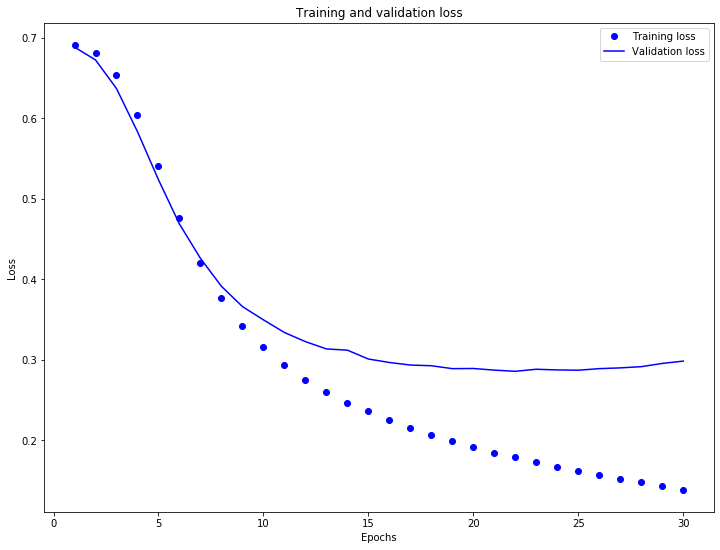

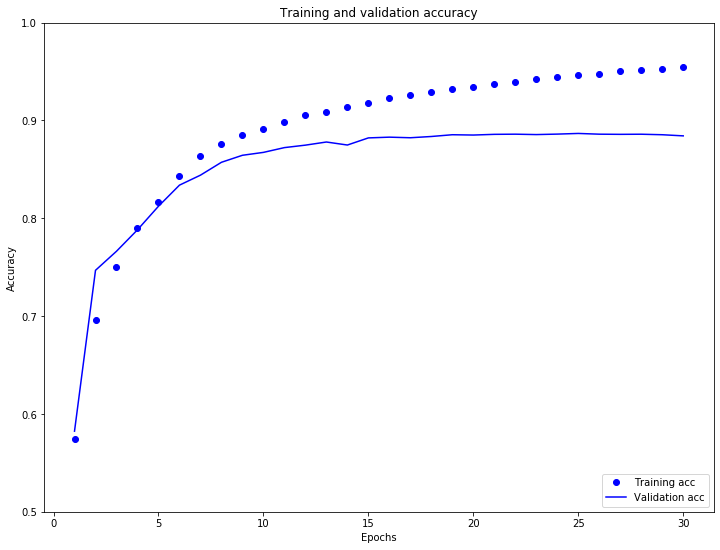

In [32]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

#### Retrieve the learned embeddings
Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [36]:
# model.layers[]: get the layer information
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


We will now write the weights to disk. To use the [`Embedding Projector`](http://projector.tensorflow.org/), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [37]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# For google colab
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

#### Visualize the embeddings
To visualize our embeddings we will upload them to the embedding projector.

Open the Embedding Projector.
- Click on "Load data".
- Upload the two files we created above: vecs.tsv and meta.tsv. 

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.